# Weather Modeling

![Equator Image](images/globalweather.jpg)

You may know how the weather changes as you approach the equator, but how would you prove it if pressed? In the following demonstration, I'll be creating a Python script to visualize the weather of 500+ cities across the world, of varying distance from the equator. To accomplish this, I will utilize a simple Python library, the OpenWeatherMap API, and a little common sense to create a representative model of weather across world cities.

The objective will be to build a series of scatter plots to showcase the following relationships:
- Temperature (F) vs. Latitude
- Humidity (%) vs. Latitude
- Cloudiness (%) vs. Latitude
- Wind Speed (mph) vs. Latitude

For a refresher, here is a quick orientation to the [geographic coordinate system](http://google.com).

The OpenWeatherMap API exposes weather data from a network of over 40,000 weather stations worldwide. For getting started with the OpenWeatherMap API, visit their [getting started page](https://openweathermap.org/appid) to request a key.

For this analysis, I also used:
- An OpenWeatherMap API wrapper library called openweathermapy, which can be found [here](https://github.com/crazycapivara/openweathermapy).
- Citipy, a library that locates the nearest city to a given set of geocoordinates, citipy, which can be found [here](https://github.com/wingchen/citipy).

Install these two libraries with your favorite package manager to follow along!

## Methodology

1. Generate a sufficiently large sample of random geocoordinates.
2. Use these geocoordinates and citipy to generate a list of the closest cities to each geocoordinate.
3. Use the list of cities to generate a series of API calls to OpenWeatherMap (which only accepts city names), retrieving and storing:
    - Actual latitude and longitude of city
    - Current temperature, humidity, cloudiness, and wind speed.
4. Covert stored data to a PANDAS dataframe and plot weather measurements as a function of latitude.

### Import dependencies:

In [2]:
import pandas as pd
import openweathermapy as ow
from citipy import citipy
import random
import requests
import json
import matplotlib.pyplot as plt

### Random latitude and longitude generation

First, lets create an array with 2000 latitudes and another with 2000 longitudes.
- Let's evenly space them out across the globe to get a wide range of locations.
- Note that:
  - Latitudes range from -90 to 90
  - Longitudes range from -180 to 180
  - Here we will take a list of 2000 numbers rather than 500.
      - This will help us avoid doubles of one city later in the script.
          - Each time we cross-reference through an api, there will be cities that there is no data for, therefore we need a surplus of input possibilities

In [3]:
# create empty lists to hold random lat/longs
latitudes = []
longitudes = []

# populate the lists using the random library
for x in range(0, 2000):
    latitudes.append(random.randint(-90,90))
    longitudes.append(random.randint(-180,180))

In [4]:
len(latitudes)

2000

In [5]:
len(longitudes)

2000

### Translating latitudes and longitudes to city names

Now we have to feed these longitudes and latitudes into citipy to output a list of 500 cities (with no doubles):

In [6]:
# create empty lists to hold city information
cities = []
countries = []
newlats = []
newlongs = []
counter = 0
incrementer = 0

while counter < 600:
    # extract geocoordinates from random list
    lat = latitudes[incrementer]
    lon = longitudes[incrementer]
    # look up nearest city and its country code
    city = citipy.nearest_city(lat, lon)
    name = city.city_name
    country = city.country_code
    # ensure the city is not already in list
    if name not in cities:
        # log progress
        print(len(cities))
        # add city, lat, long, country to respective lists
        cities.append(name)
        countries.append(country)
        newlats.append(lat)
        newlongs.append(lon)
        # increment counter and incrementer
        counter = counter + 1
        incrementer = incrementer + 1
    else:
        incrementer = incrementer + 1
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Now lets check that the lists are of proper length, and that they contain sensical data

In [7]:
len(cities)

600

In [22]:
cities[0]

'berlevag'

In [9]:
len(countries)  

600

In [23]:
countries[0]

'no'

### Preparation and testing of OpenWeatherMap API call

Now lets prepare the keys and url for calls to OWM api, specifically the weather check API:

In [10]:
api_key = '5ef1cc648f78446fbe0d9dd0d90e6060'
base_url = 'http://api.openweathermap.org/data/2.5/weather?'
# London,uk
url = base_url + '&APPID=' + api_key + '&q='
url

'http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q='

Now we can iterate over the list of cities and country codes to get our weather metrics:
- Temperature (F) 
  - ['main']['temp']
- Humidity (%)
  - ['main']['humidity']
- Cloudiness (%) 
  - ['clouds']['all']
- Wind Speed (mph)
  - ['wind']['speed']
  
Let's see how the json is laid out:

In [11]:
# construct query URL and store response JSON
ajson = requests.get(url + 'london,uk').json()

In [12]:
# pretty-print JSON
print(json.dumps(ajson, indent=4, sort_keys=True))

{
    "base": "stations",
    "clouds": {
        "all": 0
    },
    "cod": 200,
    "coord": {
        "lat": 51.51,
        "lon": -0.13
    },
    "dt": 1536879000,
    "id": 2643743,
    "main": {
        "humidity": 62,
        "pressure": 1022,
        "temp": 285.28,
        "temp_max": 288.15,
        "temp_min": 283.15
    },
    "name": "London",
    "sys": {
        "country": "GB",
        "id": 5091,
        "message": 0.0055,
        "sunrise": 1536816812,
        "sunset": 1536862660,
        "type": 1
    },
    "visibility": 10000,
    "weather": [
        {
            "description": "clear sky",
            "icon": "01n",
            "id": 800,
            "main": "Clear"
        }
    ],
    "wind": {
        "deg": 230,
        "speed": 3.1
    }
}


### Retrieval of current weather data

Now that we know the structure of the JSON, we can create a while loop to call the API and extract the relevant data for storage

In [13]:
# create empty lists to store parts of JSON response
newcities = []
newerlats = []
newerlongs = []
newcountries = []
temperatures = []
humidities = []
clouds = []
windspeeds = []
counter = 0
incrementer = 0

# continue calling API until 500 successful calls
while counter < 500:
    # read city, country, lat, long from list
    city = cities[incrementer]
    country = countries[incrementer]
    latitude = newlats[incrementer]
    longitude = newlongs[incrementer]
    # coustruct query URL and call
    tempurl = url + city + ',' + country
    thejson = requests.get(tempurl).json()
    # log API call
    print('requesting data for: ' + city)
    print('at url: ' + tempurl)
    
    try:
        # retrieve data from response JSON
        # convert temp from kelvin to farenheit
        temp = ((float(thejson['main']['temp']) - 273.15) * (9/5)) + 32  
        hum = thejson['main']['humidity']
        cld = thejson['clouds']['all']
        wind = thejson['wind']['speed']
    
        # store response data in respective lists
        temperatures.append(temp)
        humidities.append(hum)
        clouds.append(cld)
        windspeeds.append(wind)
        
        # store query data
        newcities.append(city)
        newcountries.append(country)
        newerlats.append(latitude)
        newerlongs.append(longitude)

        print(city + ' successfully added as record #' + str(counter))
        
        counter = counter + 1
        incrementer = incrementer + 1
    
    except:
        print(city + ' not found in owm, moving on...')
        incrementer = incrementer + 1

requesting data for: berlevag
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=berlevag,no
berlevag successfully added as record #0
requesting data for: norman wells
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=norman wells,ca
norman wells successfully added as record #1
requesting data for: rikitea
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=rikitea,pf
rikitea successfully added as record #2
requesting data for: san cristobal
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=san cristobal,ec
san cristobal successfully added as record #3
requesting data for: aripuana
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=aripuana,br
aripuana successfully added as record #4
requesting data for: banda aceh
at url: http://api.openweathermap.org/data/2

requesting data for: butaritari
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=butaritari,ki
butaritari successfully added as record #37
requesting data for: cap malheureux
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=cap malheureux,mu
cap malheureux successfully added as record #38
requesting data for: bredasdorp
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=bredasdorp,za
bredasdorp successfully added as record #39
requesting data for: faanui
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=faanui,pf
faanui successfully added as record #40
requesting data for: albany
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=albany,au
albany successfully added as record #41
requesting data for: saint-philippe
at url: http://api.openweathermap.org/dat

requesting data for: bonavista
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=bonavista,ca
bonavista successfully added as record #77
requesting data for: sentyabrskiy
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=sentyabrskiy,ru
sentyabrskiy not found in owm, moving on...
requesting data for: rawson
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=rawson,ar
rawson successfully added as record #78
requesting data for: iqaluit
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=iqaluit,ca
iqaluit successfully added as record #79
requesting data for: vangaindrano
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=vangaindrano,mg
vangaindrano successfully added as record #80
requesting data for: touros
at url: http://api.openweathermap.org/data/2.5/weat

requesting data for: atuona
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=atuona,pf
atuona successfully added as record #118
requesting data for: szalkszentmarton
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=szalkszentmarton,hu
szalkszentmarton successfully added as record #119
requesting data for: varzea da palma
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=varzea da palma,br
varzea da palma successfully added as record #120
requesting data for: esperance
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=esperance,au
esperance successfully added as record #121
requesting data for: saint-pierre
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=saint-pierre,re
saint-pierre successfully added as record #122
requesting data for: nyurba
at url: 

requesting data for: laguna
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=laguna,br
laguna not found in owm, moving on...
requesting data for: pangnirtung
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=pangnirtung,ca
pangnirtung successfully added as record #161
requesting data for: los llanos de aridane
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=los llanos de aridane,es
los llanos de aridane successfully added as record #162
requesting data for: gibara
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=gibara,cu
gibara successfully added as record #163
requesting data for: te anau
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=te anau,nz
te anau successfully added as record #164
requesting data for: sao filipe
at url: http://api.openweath

requesting data for: charagua
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=charagua,bo
charagua successfully added as record #198
requesting data for: vila velha
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=vila velha,br
vila velha successfully added as record #199
requesting data for: juneau
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=juneau,us
juneau successfully added as record #200
requesting data for: sennoy
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=sennoy,ru
sennoy successfully added as record #201
requesting data for: rundu
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=rundu,na
rundu successfully added as record #202
requesting data for: eyl
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe

requesting data for: toliary
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=toliary,mg
toliary not found in owm, moving on...
requesting data for: nicoya
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=nicoya,cr
nicoya successfully added as record #239
requesting data for: wilmington
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=wilmington,us
wilmington successfully added as record #240
requesting data for: ilebo
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=ilebo,cd
ilebo successfully added as record #241
requesting data for: santarem
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=santarem,br
santarem not found in owm, moving on...
requesting data for: talaya
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe

requesting data for: balikpapan
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=balikpapan,id
balikpapan successfully added as record #278
requesting data for: corralillo
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=corralillo,cu
corralillo successfully added as record #279
requesting data for: nago
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=nago,jp
nago successfully added as record #280
requesting data for: muriwai beach
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=muriwai beach,nz
muriwai beach successfully added as record #281
requesting data for: gairo
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=gairo,tz
gairo successfully added as record #282
requesting data for: namatanai
at url: http://api.openweathermap.org/data/2.5/weathe

requesting data for: manono
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=manono,cd
manono successfully added as record #321
requesting data for: gat
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=gat,ly
gat not found in owm, moving on...
requesting data for: saint-francois
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=saint-francois,gp
saint-francois successfully added as record #322
requesting data for: biak
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=biak,id
biak successfully added as record #323
requesting data for: rio grande
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=rio grande,br
rio grande successfully added as record #324
requesting data for: borogontsy
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc64

requesting data for: san patricio
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=san patricio,mx
san patricio successfully added as record #361
requesting data for: sovetskiy
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=sovetskiy,ru
sovetskiy successfully added as record #362
requesting data for: dzhusaly
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=dzhusaly,kz
dzhusaly not found in owm, moving on...
requesting data for: isla vista
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=isla vista,us
isla vista successfully added as record #363
requesting data for: college
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=college,us
college successfully added as record #364
requesting data for: mehamn
at url: http://api.openweathermap.org/data/2.5/

requesting data for: paamiut
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=paamiut,gl
paamiut successfully added as record #398
requesting data for: at-bashi
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=at-bashi,kg
at-bashi successfully added as record #399
requesting data for: shache
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=shache,cn
shache successfully added as record #400
requesting data for: gympie
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=gympie,au
gympie successfully added as record #401
requesting data for: vaitupu
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=vaitupu,wf
vaitupu not found in owm, moving on...
requesting data for: brainerd
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0

requesting data for: uba
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=uba,br
uba not found in owm, moving on...
requesting data for: tias
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=tias,es
tias successfully added as record #442
requesting data for: kupang
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=kupang,id
kupang successfully added as record #443
requesting data for: kosh-agach
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=kosh-agach,ru
kosh-agach successfully added as record #444
requesting data for: turukhansk
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=turukhansk,ru
turukhansk successfully added as record #445
requesting data for: youghal
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd

requesting data for: clyde river
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=clyde river,ca
clyde river successfully added as record #479
requesting data for: lasa
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=lasa,cn
lasa not found in owm, moving on...
requesting data for: bilma
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=bilma,ne
bilma successfully added as record #480
requesting data for: biltine
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=biltine,td
biltine successfully added as record #481
requesting data for: gasa
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0d90e6060&q=gasa,bt
gasa successfully added as record #482
requesting data for: tres arroyos
at url: http://api.openweathermap.org/data/2.5/weather?&APPID=5ef1cc648f78446fbe0d9dd0

In [14]:
len(newcities)

500

### Creating final dataframe and plotting

In [15]:
df = pd.DataFrame({'City': newcities,
                   'Latitude': newerlats,
                   'Longitude': newerlongs,
                   'Temperature': temperatures,
                   'Humidity': humidities,
                   'Cloud Cover': clouds,
                   'Wind Speed': windspeeds})

df.head()

,City,Cloud Cover,Humidity,Latitude,Longitude,Temperature,Wind Speed
0,berlevag,92,100,76,30,47.741,3.58
1,norman wells,40,36,70,-121,46.400,7.20
2,rikitea,12,99,-50,-140,74.471,6.03
3,san cristobal,92,100,-1,-88,62.681,0.68
4,aripuana,12,65,-9,-59,84.101,1.33


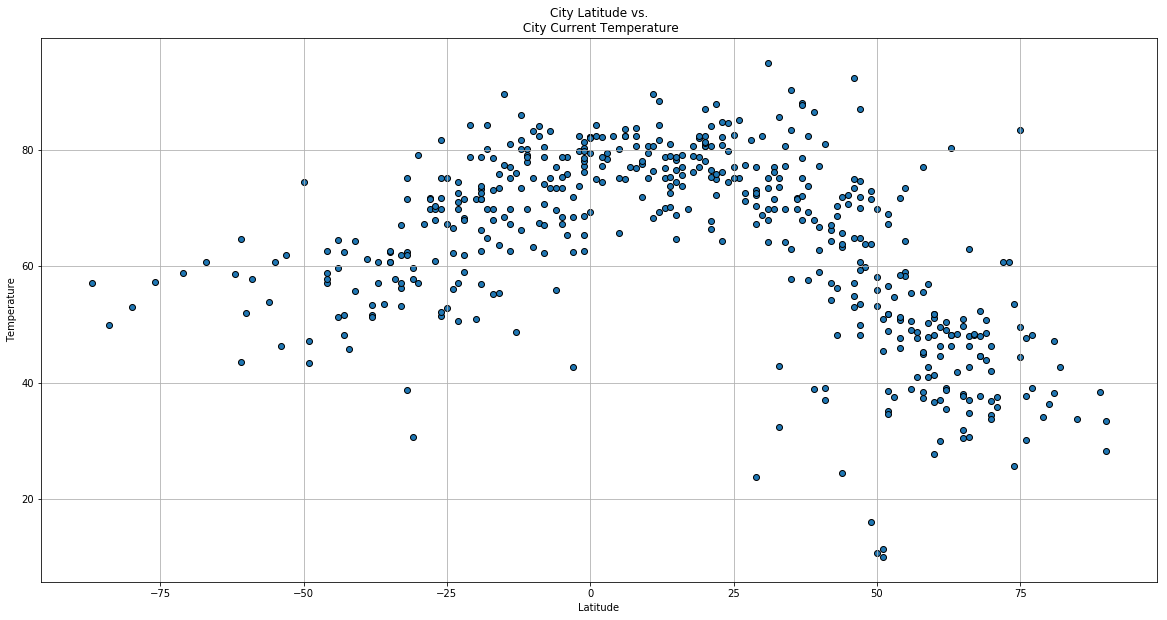

In [16]:
plt.figure(figsize=(20,10))
plt.scatter(df['Latitude'], df['Temperature'], edgecolor='black')
plt.xlabel('Latitude')
plt.ylabel('Temperature')
plt.title('City Latitude vs.\n City Current Temperature')
plt.grid()
plt.savefig('output_files/lat_vs_temp.png')
plt.show()

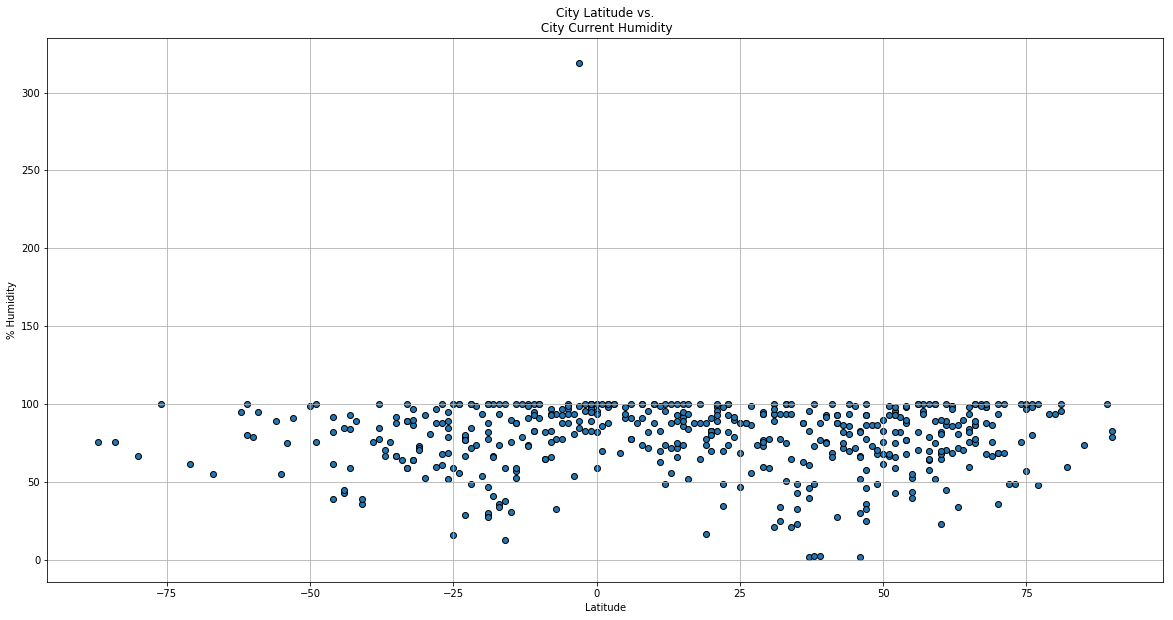

In [17]:
plt.figure(figsize=(20,10))
plt.scatter(df['Latitude'], df['Humidity'], edgecolor='black')
plt.xlabel('Latitude')
plt.ylabel('% Humidity')
plt.title('City Latitude vs.\n City Current Humidity')
plt.grid()
plt.savefig('output_files/lat_vs_hum.png')
plt.show()

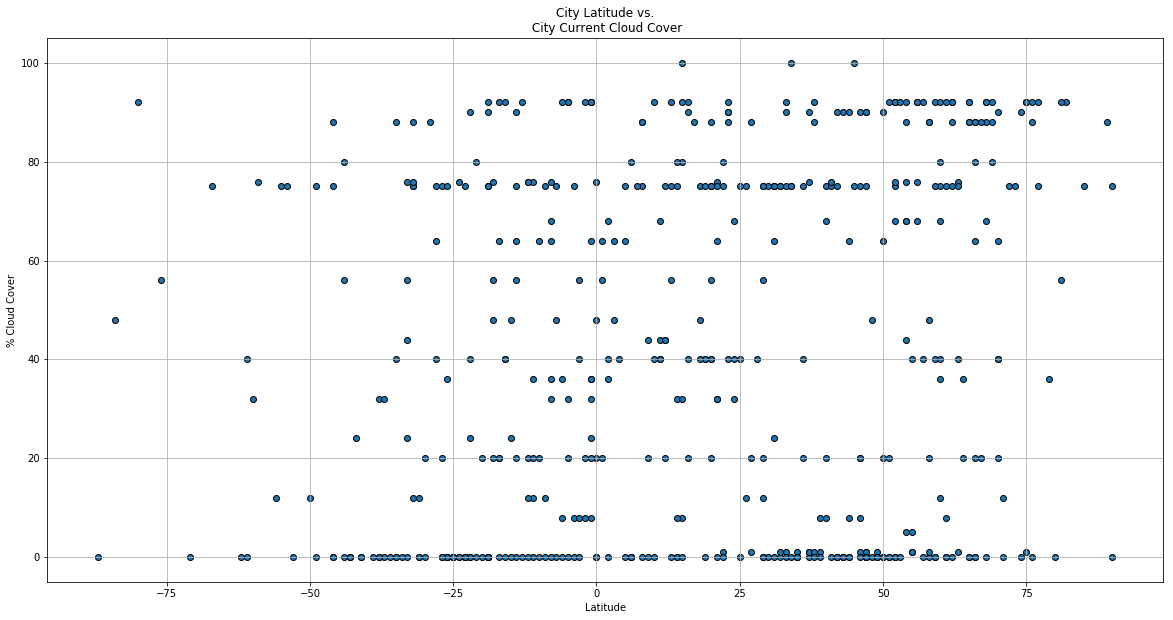

In [18]:
plt.figure(figsize=(20,10))
plt.scatter(df['Latitude'], df['Cloud Cover'], edgecolor='black')
plt.xlabel('Latitude')
plt.ylabel('% Cloud Cover')
plt.title('City Latitude vs.\n City Current Cloud Cover')
plt.grid()
plt.savefig('output_files/lat_vs_cld.png')
plt.show()

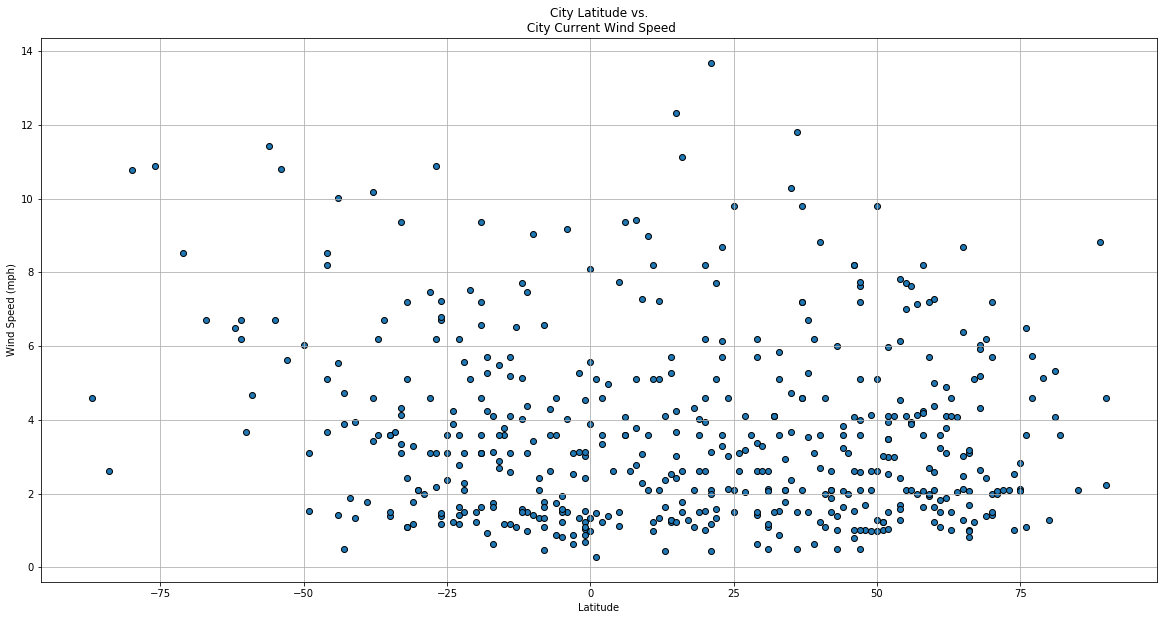

In [19]:
plt.figure(figsize=(20,10))
plt.scatter(df['Latitude'], df['Wind Speed'], edgecolor='black')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title('City Latitude vs.\n City Current Wind Speed')
plt.grid()
plt.savefig('output_files/lat_vs_wind.png')
plt.show()

In [20]:
# store dataframe as output CSV
df.to_csv('output_files/weather_vs_latitude.csv')

### Conclusions

- Temperature generally increases as you approach the equator
- As it is summer, the temperature peak are shifted to the northern latitudes
- Humidity tends to be lowest around 25 degrees away from the equator
- There appears to be no correllation between latitude and either cloud cover or wind speed